In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

data = pd.read_csv("/kaggle/input/us-flights-data-2008/2008.csv")
data = data[data['Month'] == 1]
data.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [2]:
# Уберем лишнее
data_flight = data[['DayofMonth', 'DepTime', 'ArrTime', 'AirTime','Origin', 'Dest']].copy()

# Вермя уже пердставлено в виде 100*hours+minutes. Преобразуем к виду 10000*dat+100*hours+minutes чтобы проще считать.
data_flight['DepTimeM'] = data_flight.apply(lambda a: a['DayofMonth']*10000 + a['DepTime'], axis=1)
data_flight['ArrTimeM'] = data_flight.apply(lambda a: a['DayofMonth']*10000 + a['ArrTime'] if (a['ArrTime'] > a['DepTime']) 
                                           else (a['DayofMonth'] + 1)*10000 + a['ArrTime'], axis=1)

data_flight.head()

,DayofMonth,DepTime,ArrTime,AirTime,Origin,Dest,DepTimeM,ArrTimeM
0,3,2003.0,2211.0,116.0,IAD,TPA,32003.0,32211.0
1,3,754.0,1002.0,113.0,IAD,TPA,30754.0,31002.0
2,3,628.0,804.0,76.0,IND,BWI,30628.0,30804.0
3,3,926.0,1054.0,78.0,IND,BWI,30926.0,31054.0
4,3,1829.0,1959.0,77.0,IND,BWI,31829.0,31959.0


Начнем распостранять заразу из аэропорта Chicago Midway. 

In [3]:

first_infected = 'MDW'
inf_time = 1.0

data_flight['infected'] =  data_flight.apply(lambda a: 1 if a['Origin'] == first_infected else 0, axis=1)
data_flight['infected_time'] = data_flight.apply(lambda a: 0 if a['Origin'] == first_infected else 1000000, axis=1)

data_flight.head()

,DayofMonth,DepTime,ArrTime,AirTime,Origin,Dest,DepTimeM,ArrTimeM,infected,infected_time
0,3,2003.0,2211.0,116.0,IAD,TPA,32003.0,32211.0,0,1000000
1,3,754.0,1002.0,113.0,IAD,TPA,30754.0,31002.0,0,1000000
2,3,628.0,804.0,76.0,IND,BWI,30628.0,30804.0,0,1000000
3,3,926.0,1054.0,78.0,IND,BWI,30926.0,31054.0,0,1000000
4,3,1829.0,1959.0,77.0,IND,BWI,31829.0,31959.0,0,1000000


In [4]:
import random 

# Допущение(или упрощение):
# Если рейс вылетает в тот же час, в котором произошло заражение, то рейс не считается инфецированным. 
# Поэтому далее проверяем кол-во заразившихся каждый час.
# Можно считать точнее. На функцию прохода по базе вылетов это не отражается.

def InfectionStep(data_flight, p, courrent_time, infected_airports, verbose=True):
    
    ans = {}
    # itertuples[0]
    # Pandas(Index=0, DayofMonth=3, DepTime=2003.0, ArrTime=2211.0, AirTime=116.0, Origin='IAD', 
    # [6]Dest='TPA', [7]DepTimeM=32003.0, [8]ArrTimeM=32211.0, [9]infected=0, [10]infected_time=1000000)
    num_infected = 0
    n = 0
    for item in data_flight.itertuples():

        # Если рейс прибыл, а на момент вылета аэропорт вылета был уже заражен
        if (item[8] < courrent_time) and (item[7] > item[10]):
            n += 1
            
            #Если аэропорт уже заражен
            dest_airport = item[6]
            if dest_airport in infected_airports:
                #print(dest_airport)
                continue
            
            # кидаем монетку, заражаем аэропорт.
            if (random.choices(population=[1,0], weights=[p,1-p]) == [1]):
                #print(item[0])
                infected_time = item[8]
                infected_airport = item[6]
                
                ans.update({int(infected_time): infected_airport})
                
                data_flight.loc[data_flight[data_flight['Origin'] == infected_airport].index, "infected"] = 1
                data_flight.loc[data_flight[data_flight['Origin'] == infected_airport].index, "infected_time"] = infected_time
                #print(data_flight.loc[item[0], : ])
                #print(infected_airport, infected_time)
                num_infected += 1
                
    if (verbose): print("Заражено новых аэропортов:", num_infected, "Рейсов из инфицированных аэропортов:", n)
    
    return ans


In [5]:
num_of_steps = 10
all_airports = set(data_flight['Origin'].unique())
all_airports_num = len(all_airports)

# заразность 
p_list = [0.01, 0.05, 0.1, 0.5, 1.] 
infected_airports_list = []
rel_infected_airports_list = []


for p in p_list:
    print ("\nCalculation for p =", p)

    data_flight_copy = data_flight.copy()
    infected_airports = set([first_infected])
    i = 1
    
    for courrent_time in range(10000 + 100*1, 10000 + 100*(num_of_steps + 1), 100):          
        print(">> step ", i)
        i+=1
        new_infected = InfectionStep(data_flight_copy, p, courrent_time, infected_airports)                

        #print(list(new_infected.values()))
        infected_airports.update(set(new_infected.values()))

        print("Всего заражено:", len(infected_airports), "Доля зараженных:",  len(infected_airports)/all_airports_num)
    
    infected_airports_list.append(len(infected_airports))    
    rel_infected_airports_list.append(len(infected_airports)/all_airports_num) 

print(p_list)
print(infected_airports_list)
print(rel_infected_airports_list)


Calculation for p = 0.01
>> step  1
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 0
Всего заражено: 1 Доля зараженных: 0.0034965034965034965
>> step  2
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 1
Всего заражено: 1 Доля зараженных: 0.0034965034965034965
>> step  3
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 3
Всего заражено: 1 Доля зараженных: 0.0034965034965034965
>> step  4
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 5
Всего заражено: 1 Доля зараженных: 0.0034965034965034965
>> step  5
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 5
Всего заражено: 1 Доля зараженных: 0.0034965034965034965
>> step  6
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 5
Всего заражено: 1 Доля зараженных: 0.0034965034965034965
>> step  7
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 5
Всего заражено: 1 Доля зараженных: 0.0034965034965034965
>> step  8
Заражено но

Text(0.5, 1.0, 'Relative to all airports')

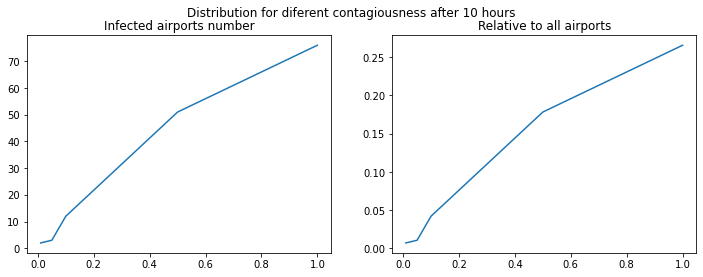

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2,  figsize=(12,4))
fig.suptitle("Distribution for diferent contagiousness after 10 hours")
axes[0].plot(p_list, infected_airports_list)
axes[0].set_title('Infected airports number')
axes[1].plot(p_list, rel_infected_airports_list)
axes[1].set_title('Relative to all airports')


Прогоним симуляцию на 50 часов для каждой вероятности. Для каждых 6 часов симуляции посчитаем, какую долю аэропортов от общего их числа, было зараженр к этому моменту времени. Построим графики.


In [7]:
num_of_steps = 50
all_airports = set(data_flight['Origin'].unique())
all_airports_num = len(all_airports)

# заразность 
p_list = [0.01, 0.05, 0.1, 0.5, 1.] 
all_infected_airports_list = []

infected_airports_dict = dict()

for p in p_list:
    print ("\nCalculation for p =", p)

    data_flight_copy = data_flight.copy()
    infected_airports = set([first_infected])
    i = 1
    infected_airports_list = []
    
    
    for courrent_time in range(10000 + 100*1, 10000 + 100*(num_of_steps + 1), 100):          
        i+=1
        new_infected = InfectionStep(data_flight_copy, p, courrent_time, infected_airports)                
        
        # заодно сохраним весь словарь для последнего задания
        if (p == 0.5):
            infected_airports_dict.update(new_infected)
        
        #print(list(new_infected.values()))
        infected_airports.update(set(new_infected.values()))

        #print("Всего заражено:", len(infected_airports), "Доля зараженных:",  len(infected_airports)/all_airports_num)
        
        # для  каждего шестого часа откладываем долю зараженных аэропортов.
        if (i%6 == 0): 
            infected_airports_list.append(len(infected_airports)/all_airports_num)    
    
    
    all_infected_airports_list.append(infected_airports_list)
    
    

print(p_list)
print(all_infected_airports_list)


Calculation for p = 0.01
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 0
Заражено новых аэропортов: 1 Рейсов из инфицированных аэропортов: 1
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 3
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 5
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 5
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 5
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 5
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 6
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 18
Заражено новых аэропортов: 1 Рейсов из инфицированных аэропортов: 33
Заражено новых аэропортов: 0 Рейсов из инфицированных аэропортов: 58
Заражено новых аэропортов: 1 Рейсов из инфицированных аэропортов: 80
Заражено новых аэропортов: 1 Рейсов из инфицированных аэропортов: 170
Заражено новых аэропортов: 3 Рейсов из инфицированных аэропортов: 304
Заражено новых

Построим зависимость количества зараженных аэропортов от времени для разных вероятностей заражения.

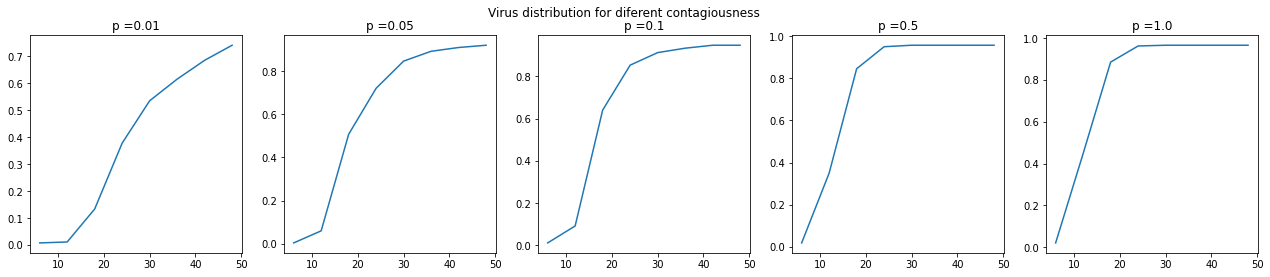

In [8]:
h_list = [i for i in range(6,50,6)]
fig, axes = plt.subplots(nrows=1, ncols=5,  figsize=(22,4))
fig.suptitle("Virus distribution for diferent contagiousness")
for i in range(5):
    axes[i].plot(h_list, all_infected_airports_list[i])
    axes[i].set_title('p ='+str(p_list[i]))


# Работа с NetworkX

Сначала подготовим датафрейм для графа. Посчитаем количество перелетов для каждого направления.

In [9]:
data_flight_copy.groupby(['Origin','Dest'])['AirTime'].count()

Origin  Dest
ABE     ATL      73
        CLE      75
        CLT      30
        CVG      26
        DTW      79
               ... 
YUM     IPL      57
        LAS      16
        LAX      88
        PHX     150
        SLC      61
Name: AirTime, Length: 4669, dtype: int64

In [10]:
data_flight_copy = data_flight.copy()

print(data_flight_copy.shape)
data_flight_copy['val'] = data_flight_copy.groupby(['Origin','Dest'])['AirTime'].transform("count")
data_flight_copy['rel_val'] = data_flight_copy['val'] / data_flight_copy.shape[0]



(605765, 10)


Число вершин: 287
Число ребер: 2386


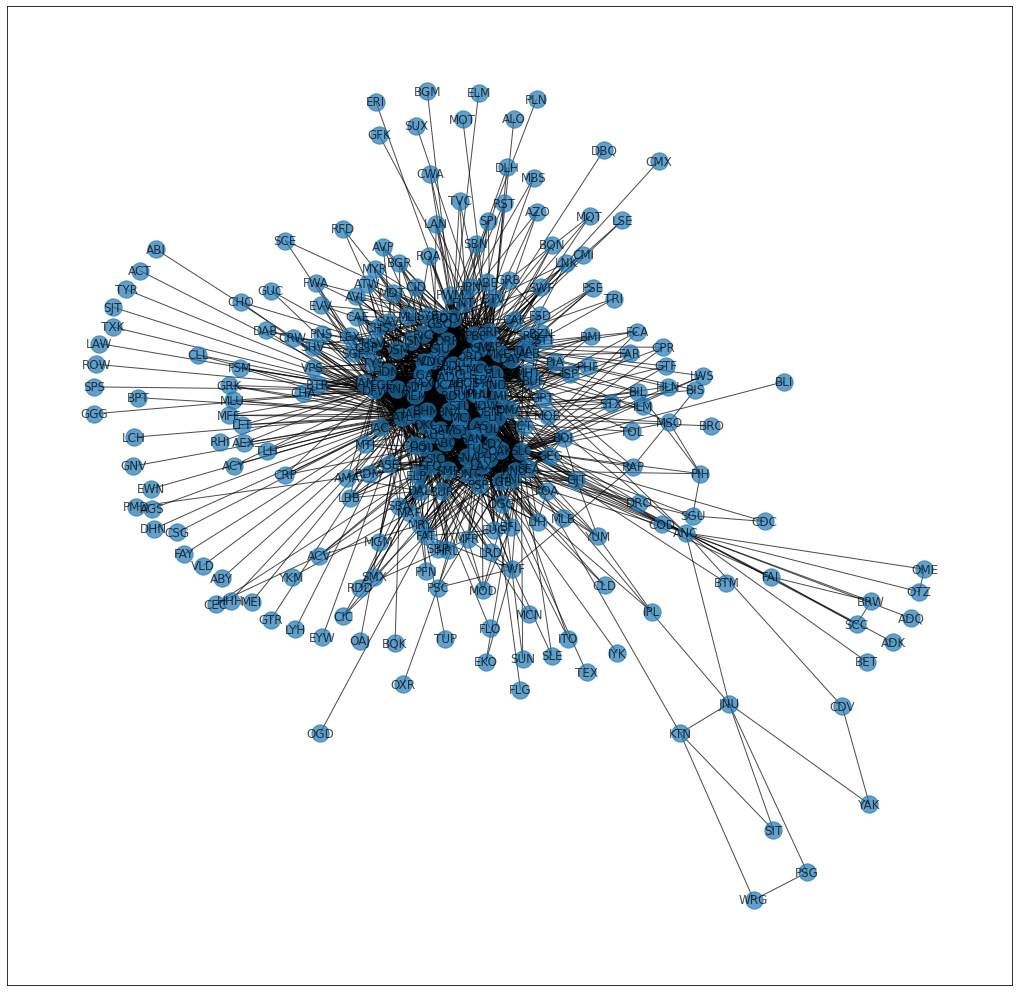

In [11]:
import networkx as nx

# Построим граф и посмотрим на него и его параметры.

G=nx.from_pandas_edgelist(data_flight_copy, 'Origin', 'Dest', 'rel_val')
print("Число вершин:", G.number_of_nodes())
print("Число ребер:", G.number_of_edges())

plt.subplots(figsize=(18,18))
nx.draw_networkx(G,  alpha=0.7,)

Расчитаем различные характеристики графов. Посомтри на их связь с временем распостранения инфекции.

In [12]:
from collections import Counter

g_centrality = nx.betweenness_centrality(G)
degree_centrality_counts = Counter(g_centrality)
degree_centrality_counts.most_common(10)


[('ATL', 0.2298672845218599),
 ('DFW', 0.11683972508142126),
 ('SLC', 0.10796257287086754),
 ('ORD', 0.10555513771151391),
 ('MSP', 0.09562936495418102),
 ('IAH', 0.07086942675426158),
 ('DTW', 0.0690298723790019),
 ('DEN', 0.061029865886658256),
 ('ANC', 0.060927562009108906),
 ('SEA', 0.045802074271299)]

In [13]:
g_clustering = nx.clustering(G)
#g_clustering

In [14]:
g_degree = nx.degree(G)
#g_degree


In [15]:
all_data = []
for item in infected_airports_dict.items():
    all_data.append([item[1], item[0], g_centrality[item[1]], g_clustering[item[1]], g_degree[item[1]]])

all_data_df = pd.DataFrame(all_data, columns=['Airport', 'InfectionTime', 'Centrality', 'Clustering', 'Degree'])
all_data_df.head(10)

,Airport,InfectionTime,Centrality,Clustering,Degree
0,MCI,10117,0.001193,0.685859,45
1,PHL,10312,0.001726,0.639184,50
2,TPA,10323,0.003048,0.557018,57
3,BWI,10228,0.002806,0.559322,59
4,IAD,10733,0.006975,0.473295,62
5,DEN,10746,0.061030,0.235522,114
6,CLT,10712,0.011064,0.432596,71
7,CLT,10649,0.011064,0.432596,71
8,ATL,10717,0.229867,0.130120,166
9,MEM,10759,0.011656,0.352504,72


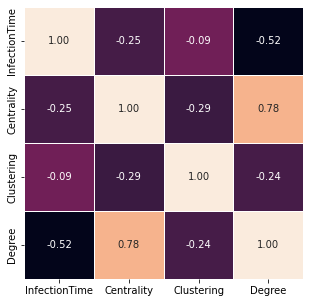

In [16]:
import seaborn as sns

plt.figure(figsize=(5, 5))
sns.heatmap(all_data_df.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

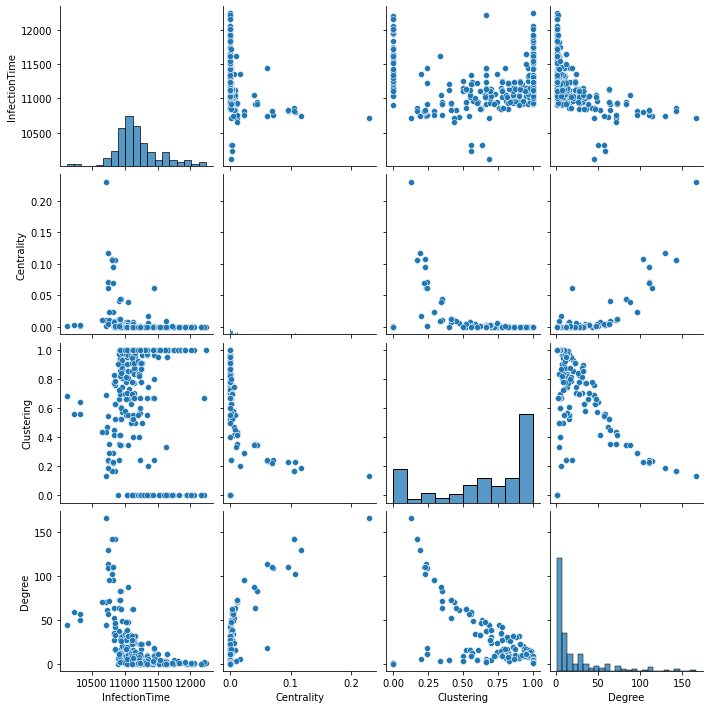

In [17]:
sns.pairplot(all_data_df);

Немного выводов. Параметры **Centrality** и **Degree** обратно корелируют с временем заражения. Чем больше **Centrality**, тем больше поток через хаб, Больше самолётов, больше возможгности заразиться. То же самое с **Degree** - чем с большим количесвом аэропортов связан хаб, тем больше вероятность того, что из одного из них прилетит "чумной" самолёт.